# 1. Package Import

In [25]:
# !pip install torchsummary

In [27]:
# basic python 
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import  Dataset, DataLoader
from torchvision.utils import make_grid
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchsummary import summary

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
device

device(type='cuda', index=0)

# 2. Download Dataset

In [16]:
def generate_loader(data, shuffle):
    return DataLoader(
        data,
        batch_size=128,
        shuffle= shuffle, 
        num_workers=2
    )

def data_init():
    
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            # transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ]
    )

    trainset = CIFAR10(
        root = "./data",
        download = True,
        train = True,
        transform = transform
    )
    
    torch.manual_seed(0)
    train, val = random_split(trainset, [len(trainset) - 5000, 5000])
    
    test = CIFAR10(
        root = "./data",
        download = True,
        train = False,
        transform = transform
    )

    return generate_loader(train, True), generate_loader(val, True), generate_loader(test, False)

In [17]:
train_loader, val_loader, test_loader = data_init()

Files already downloaded and verified
Files already downloaded and verified


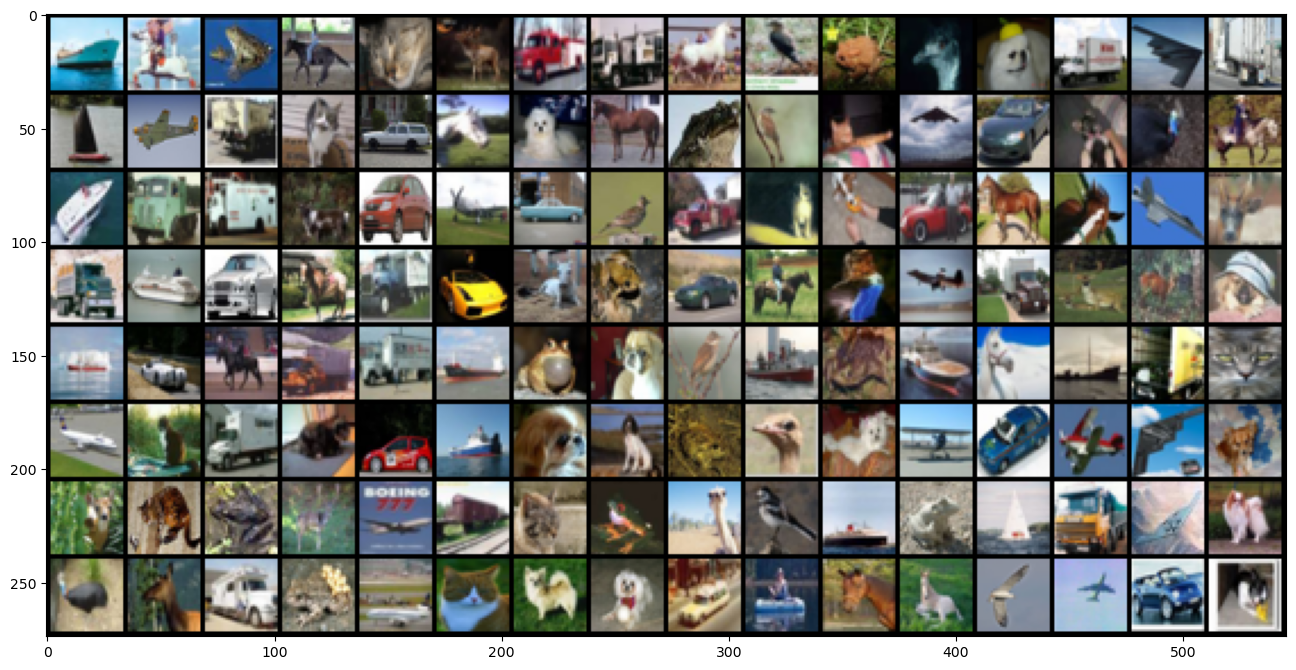

In [20]:
# See the images
for images, labels in train_loader:
    fi, ax = plt.subplots(figsize=(16,12))
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

# 3. Build CNN Model


In [67]:
import torch.nn as nn
from torch.nn import functional as F

class CNNModel(nn.Module):
    def __init__(self, batch = True, activation = "relu", pool = "max"):
        
        super(CNNModel, self).__init__()
        
        self.batchNorm = batch
        self.activation = activation
        self.pool = pool
        
        self.con = nn.ModuleList()
        self.con.append(nn.Conv2d(3,32,3,padding=1))
        self.con.append(nn.Conv2d(32,64,3,padding=1))
        self.con.append(nn.Conv2d(64,64,3,padding=1))
        
        self.batch = nn.ModuleList()
        self.batch.append(nn.BatchNorm2d(32))
        self.batch.append(nn.BatchNorm2d(64))
        self.batch.append(nn.BatchNorm2d(64))
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.maxPool = nn.MaxPool2d(2,2)
        self.avgPool = nn.AvgPool2d(2,2)
        
        self.fc_layer = nn.Sequential(
            
            nn.Flatten(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,10)
        )
      
  
    def forward(self, x):
        for i in range(len(self.con)):
            x = self.con[i](x)
            if self.batchNorm:
                x = self.batch[i](x)
            
            if self.activation == "relu":
                x = self.relu(x)
            elif self.activation == 'sigmoid':
                x = self.sigmoid(x)
            
            if self.pool == "max":
                x = self.maxPool(x)
            elif self.pool == "avg":
                x = self.avgPool(x)
                
        x = self.fc_layer(x)
        
        return x

In [68]:
cnn = CNNModel().to(device)
print(cnn)

CNNModel(
  (con): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch): ModuleList(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1-2): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgPool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [69]:
summary(cnn, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
      BatchNorm2d-10             [-1, 64, 8, 8]             128
             ReLU-11             [-1, 64, 8, 8]               0
        MaxPool2d-12             [-1, 64, 4, 4]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14                  [

# 4. Ablation Study

In [85]:
def train(model, train_loader, val_loader, eps = 15):
    
    validation_accuracy, validation_loss, training_loss, training_accuracy = [], [], [], []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(eps):
        batch_train_loss, total, correct = 0, 0, 0
        for i, data in enumerate(train_loader, 0):
            batch_size = data[0].shape[0]
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            predicted = torch.argmax(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total += labels.size(0)
            correct += torch.sum(predicted == labels).item()
            batch_train_loss += loss.item()
            
        training_accuracy.append(correct/total)
        training_loss.append(batch_train_loss/total*batch_size)
        
        print(f'Epoch - {epoch + 1:02d}')
        print(f'Train Loss - {training_loss[-1]:.4f} | Train Acc - {training_accuracy[-1]:.4f}')
        
        correct, total = 0, 0
        with torch.no_grad():
            batch_loss, correct, total = 0, 0, 0
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                predicted = torch.argmax(outputs.data, 1)
                total += labels.size(0)
                correct += torch.sum(predicted == labels).sum().item()
                batch_loss += loss.item()
    
        validation_loss.append(batch_loss/total*batch_size)
        validation_accuracy.append(correct /total)
        print(f'Valid loss - {validation_loss[-1]:.4f} | Valid Acc - {validation_accuracy[-1]:.4f}\n')
        
    print('Finished Training')
    return training_accuracy, training_loss, validation_accuracy, validation_loss

In [86]:
def test(model, test_loader):
    correct, total = 0, 0
    with torch.no_grad():
        batch_loss, correct, total = 0, 0, 0
        for data in val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data, 1)
            total += labels.size(0)
            correct += torch.sum(predicted == labels).sum().item()
    test_acc = correct /total
    print(f'Test Acc - {test_acc:.4f}\n')
    return test_acc

In [87]:
def plot_result(train_lst, val_lst, string = "Loss"):
    plt.plot(train_lst, label='Train %s'%(string))
    plt.plot(val_lst,label='Valid %s'%(string))
    plt.xlabel('Epoch')
    plt.ylabel(string)
    plt.title('%s Trend with Epochs'%(string))
    plt.legend()
    plt.grid()
    plt.show()

### 4.1 Batch Norm = True, Activation = "relu", Pool = "max"

In [88]:
cnn = CNNModel().to(device)
trainAccuracy, trainLoss, valAccuracy, valLoss = train(cnn, train_loader, val_loader)

Epoch - 01
Train Loss - 1.1061 | Train Acc - 0.3198
Valid loss - 0.9486 | Valid Acc - 0.4098

Epoch - 02
Train Loss - 0.8093 | Train Acc - 0.4837
Valid loss - 0.7773 | Valid Acc - 0.5152

Epoch - 03
Train Loss - 0.6820 | Train Acc - 0.5667
Valid loss - 0.6882 | Valid Acc - 0.5688

Epoch - 04
Train Loss - 0.6002 | Train Acc - 0.6211
Valid loss - 0.6198 | Valid Acc - 0.6168

Epoch - 05
Train Loss - 0.5432 | Train Acc - 0.6588
Valid loss - 0.5711 | Valid Acc - 0.6544

Epoch - 06
Train Loss - 0.5055 | Train Acc - 0.6842
Valid loss - 0.5437 | Valid Acc - 0.6712

Epoch - 07
Train Loss - 0.4718 | Train Acc - 0.7072
Valid loss - 0.5243 | Valid Acc - 0.6842

Epoch - 08
Train Loss - 0.4431 | Train Acc - 0.7232
Valid loss - 0.5024 | Valid Acc - 0.7010

Epoch - 09
Train Loss - 0.4197 | Train Acc - 0.7409
Valid loss - 0.4969 | Valid Acc - 0.7018

Epoch - 10
Train Loss - 0.3953 | Train Acc - 0.7554
Valid loss - 0.4999 | Valid Acc - 0.7200

Epoch - 11
Train Loss - 0.3787 | Train Acc - 0.7654
Valid lo

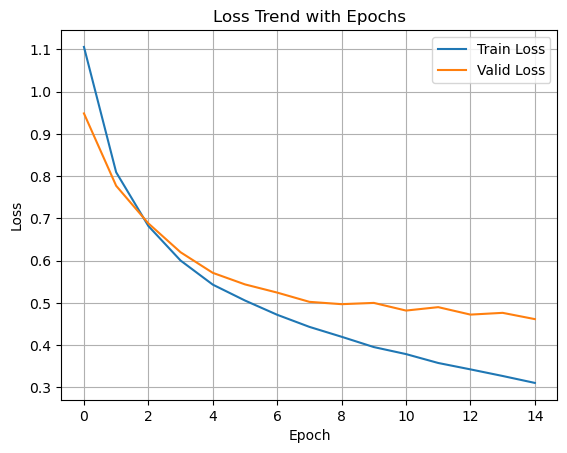

In [89]:
plot_result(trainLoss, valLoss)

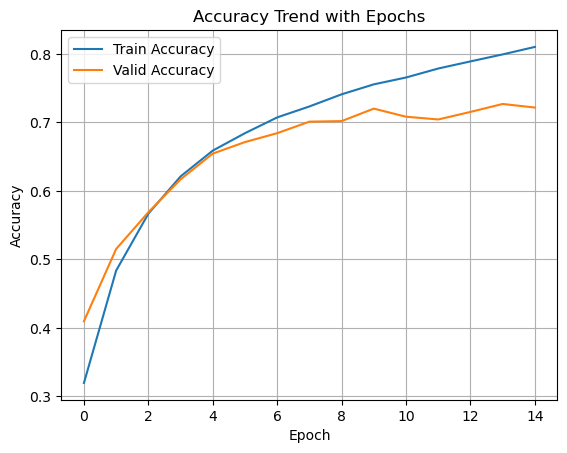

In [90]:
plot_result(trainAccuracy, valAccuracy, string = "Accuracy")

In [91]:
testAcc = test(cnn, test_loader)

Test Acc - 0.7248



### 4.2 Batch Norm = False, Activation = "relu", Pool = "max"

In [92]:
cnn2 = CNNModel(batch = False, activation = "relu", pool = "max").to(device)
trainAccuracy2, trainLoss2, valAccuracy2, valLoss2 = train(cnn2, train_loader, val_loader)

Epoch - 01
Train Loss - 1.2968 | Train Acc - 0.1001
Valid loss - 1.3260 | Valid Acc - 0.0988

Epoch - 02
Train Loss - 1.2963 | Train Acc - 0.1032
Valid loss - 1.3257 | Valid Acc - 0.1398

Epoch - 03
Train Loss - 1.2958 | Train Acc - 0.1515
Valid loss - 1.3253 | Valid Acc - 0.1474

Epoch - 04
Train Loss - 1.2950 | Train Acc - 0.1554
Valid loss - 1.3242 | Valid Acc - 0.1698

Epoch - 05
Train Loss - 1.2935 | Train Acc - 0.1826
Valid loss - 1.3220 | Valid Acc - 0.1864

Epoch - 06
Train Loss - 1.2896 | Train Acc - 0.2017
Valid loss - 1.3154 | Valid Acc - 0.2044

Epoch - 07
Train Loss - 1.2720 | Train Acc - 0.2021
Valid loss - 1.2742 | Valid Acc - 0.2048

Epoch - 08
Train Loss - 1.1867 | Train Acc - 0.2255
Valid loss - 1.1849 | Valid Acc - 0.2524

Epoch - 09
Train Loss - 1.1332 | Train Acc - 0.2589
Valid loss - 1.1516 | Valid Acc - 0.2766

Epoch - 10
Train Loss - 1.1125 | Train Acc - 0.2738
Valid loss - 1.1337 | Valid Acc - 0.2884

Epoch - 11
Train Loss - 1.0918 | Train Acc - 0.2898
Valid lo

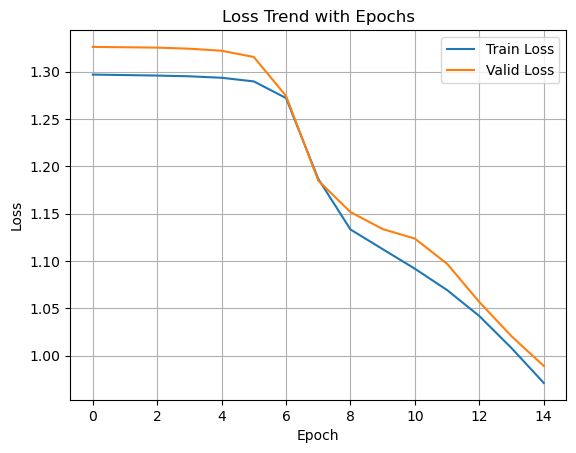

In [93]:
plot_result(trainLoss2, valLoss2)

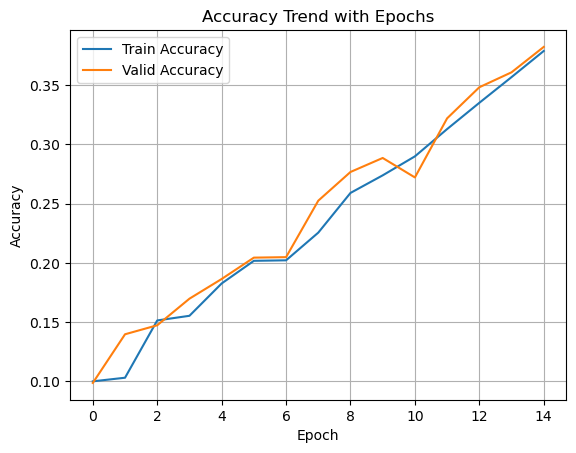

In [94]:
plot_result(trainAccuracy2, valAccuracy2, string = "Accuracy")

In [95]:
testAcc2 = test(cnn2, test_loader)

Test Acc - 0.3820



### 4.3 Batch Norm = True, Activation = "sigmoid", Pool = "max"

In [97]:
cnn3 = CNNModel(batch = True, activation = "sigmoid", pool = "max").to(device)
trainAccuracy3, trainLoss3, valAccuracy3, valLoss3 = train(cnn3, train_loader, val_loader)

Epoch - 01
Train Loss - 1.2813 | Train Acc - 0.1817
Valid loss - 1.2770 | Valid Acc - 0.2400

Epoch - 02
Train Loss - 1.1803 | Train Acc - 0.2316
Valid loss - 1.1703 | Valid Acc - 0.2224

Epoch - 03
Train Loss - 1.0954 | Train Acc - 0.2865
Valid loss - 1.1076 | Valid Acc - 0.3046

Epoch - 04
Train Loss - 0.9966 | Train Acc - 0.3487
Valid loss - 0.9913 | Valid Acc - 0.3652

Epoch - 05
Train Loss - 0.9195 | Train Acc - 0.3867
Valid loss - 0.9346 | Valid Acc - 0.3968

Epoch - 06
Train Loss - 0.8739 | Train Acc - 0.4208
Valid loss - 0.8976 | Valid Acc - 0.4270

Epoch - 07
Train Loss - 0.8382 | Train Acc - 0.4440
Valid loss - 0.8659 | Valid Acc - 0.4476

Epoch - 08
Train Loss - 0.8047 | Train Acc - 0.4702
Valid loss - 0.8266 | Valid Acc - 0.4772

Epoch - 09
Train Loss - 0.7690 | Train Acc - 0.4965
Valid loss - 0.7880 | Valid Acc - 0.4958

Epoch - 10
Train Loss - 0.7370 | Train Acc - 0.5178
Valid loss - 0.7518 | Valid Acc - 0.5188

Epoch - 11
Train Loss - 0.7014 | Train Acc - 0.5433
Valid lo

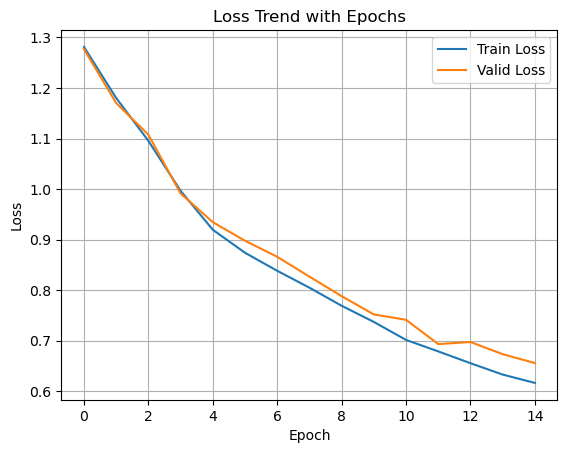

In [98]:
plot_result(trainLoss3, valLoss3)

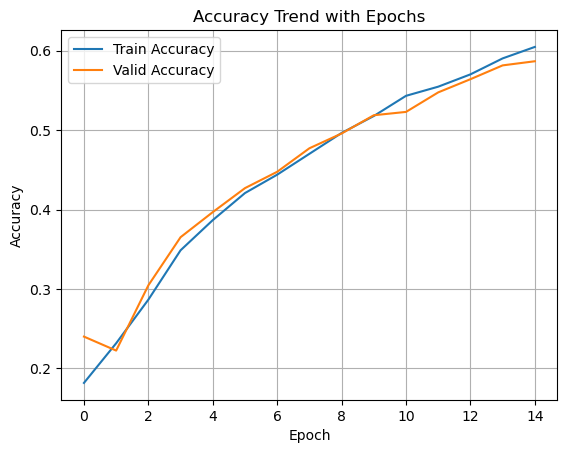

In [99]:
plot_result(trainAccuracy3, valAccuracy3, string = "Accuracy")

In [100]:
testAcc3 = test(cnn3, test_loader)

Test Acc - 0.5860



### 4.4 Batch Norm = False, Activation = "sigmoid", Pool = "max"

In [101]:
cnn4 = CNNModel(batch = False, activation = "sigmoid", pool = "max").to(device)
trainAccuracy4, trainLoss4, valAccuracy4, valLoss4 = train(cnn4, train_loader, val_loader)

Epoch - 01
Train Loss - 1.2971 | Train Acc - 0.0969
Valid loss - 1.3263 | Valid Acc - 0.0934

Epoch - 02
Train Loss - 1.2970 | Train Acc - 0.0990
Valid loss - 1.3263 | Valid Acc - 0.1012

Epoch - 03
Train Loss - 1.2969 | Train Acc - 0.0988
Valid loss - 1.3264 | Valid Acc - 0.1014

Epoch - 04
Train Loss - 1.2969 | Train Acc - 0.0993
Valid loss - 1.3265 | Valid Acc - 0.0964

Epoch - 05
Train Loss - 1.2970 | Train Acc - 0.0996
Valid loss - 1.3263 | Valid Acc - 0.1064

Epoch - 06
Train Loss - 1.2969 | Train Acc - 0.0978
Valid loss - 1.3263 | Valid Acc - 0.0964

Epoch - 07
Train Loss - 1.2969 | Train Acc - 0.1004
Valid loss - 1.3266 | Valid Acc - 0.0934

Epoch - 08
Train Loss - 1.2969 | Train Acc - 0.1017
Valid loss - 1.3263 | Valid Acc - 0.0964

Epoch - 09
Train Loss - 1.2970 | Train Acc - 0.0988
Valid loss - 1.3263 | Valid Acc - 0.1064

Epoch - 10
Train Loss - 1.2969 | Train Acc - 0.1009
Valid loss - 1.3265 | Valid Acc - 0.0934

Epoch - 11
Train Loss - 1.2969 | Train Acc - 0.0997
Valid lo

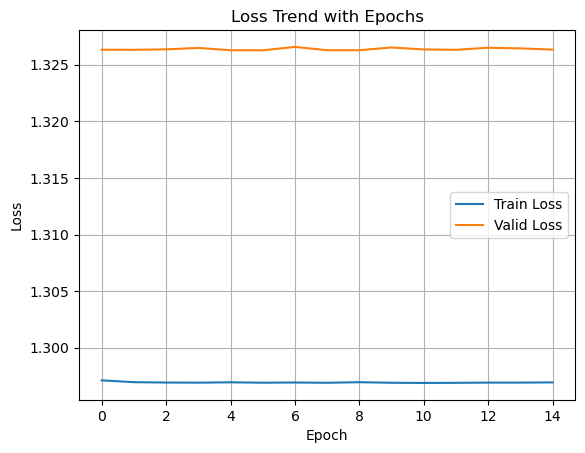

In [102]:
plot_result(trainLoss4, valLoss4)

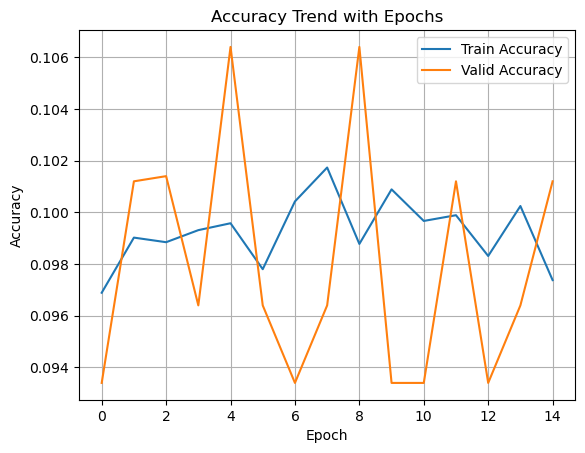

In [103]:
plot_result(trainAccuracy4, valAccuracy4, string = "Accuracy")

In [104]:
testAcc4 = test(cnn4, test_loader)

Test Acc - 0.1012



### 4.5 Batch Norm = True, Activation = "sigmoid", Pool = "avg"

In [105]:
cnn5 = CNNModel(batch = True, activation = "sigmoid", pool = "avg").to(device)
trainAccuracy5, trainLoss5, valAccuracy5, valLoss5 = train(cnn5, train_loader, val_loader)

Epoch - 01
Train Loss - 1.2770 | Train Acc - 0.1807
Valid loss - 1.2654 | Valid Acc - 0.2132

Epoch - 02
Train Loss - 1.1768 | Train Acc - 0.2386
Valid loss - 1.1744 | Valid Acc - 0.2630

Epoch - 03
Train Loss - 1.1280 | Train Acc - 0.2705
Valid loss - 1.1465 | Valid Acc - 0.2792

Epoch - 04
Train Loss - 1.0939 | Train Acc - 0.2959
Valid loss - 1.1115 | Valid Acc - 0.3144

Epoch - 05
Train Loss - 1.0539 | Train Acc - 0.3213
Valid loss - 1.0665 | Valid Acc - 0.3348

Epoch - 06
Train Loss - 1.0116 | Train Acc - 0.3494
Valid loss - 1.0233 | Valid Acc - 0.3536

Epoch - 07
Train Loss - 0.9820 | Train Acc - 0.3641
Valid loss - 1.0199 | Valid Acc - 0.3538

Epoch - 08
Train Loss - 0.9572 | Train Acc - 0.3825
Valid loss - 0.9687 | Valid Acc - 0.3852

Epoch - 09
Train Loss - 0.9341 | Train Acc - 0.3980
Valid loss - 0.9573 | Valid Acc - 0.3996

Epoch - 10
Train Loss - 0.9150 | Train Acc - 0.4105
Valid loss - 0.9725 | Valid Acc - 0.3944

Epoch - 11
Train Loss - 0.8962 | Train Acc - 0.4205
Valid lo

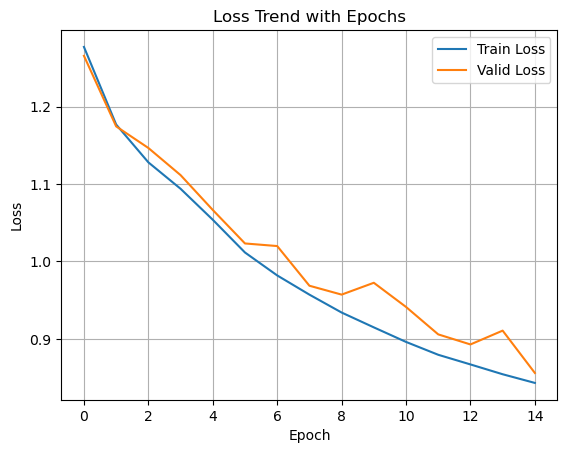

In [106]:
plot_result(trainLoss5, valLoss5)

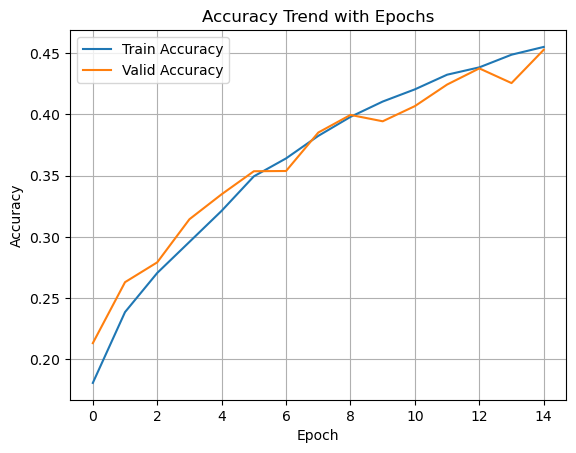

In [107]:
plot_result(trainAccuracy5, valAccuracy5, string = "Accuracy")

In [108]:
testAcc5 = test(cnn5, test_loader)

Test Acc - 0.4528



### 4.6 Batch Norm = False, Activation = "sigmoid", Pool = "avg"

In [109]:
cnn6 = CNNModel(batch = False, activation = "sigmoid", pool = "avg").to(device)
trainAccuracy6, trainLoss6, valAccuracy6, valLoss6 = train(cnn6, train_loader, val_loader)

Epoch - 01
Train Loss - 1.2970 | Train Acc - 0.0982
Valid loss - 1.3266 | Valid Acc - 0.1004

Epoch - 02
Train Loss - 1.2970 | Train Acc - 0.0985
Valid loss - 1.3265 | Valid Acc - 0.0934

Epoch - 03
Train Loss - 1.2970 | Train Acc - 0.0977
Valid loss - 1.3264 | Valid Acc - 0.0934

Epoch - 04
Train Loss - 1.2970 | Train Acc - 0.0974
Valid loss - 1.3264 | Valid Acc - 0.0964

Epoch - 05
Train Loss - 1.2969 | Train Acc - 0.0986
Valid loss - 1.3264 | Valid Acc - 0.0988

Epoch - 06
Train Loss - 1.2969 | Train Acc - 0.0976
Valid loss - 1.3262 | Valid Acc - 0.0988

Epoch - 07
Train Loss - 1.2969 | Train Acc - 0.0985
Valid loss - 1.3265 | Valid Acc - 0.1004

Epoch - 08
Train Loss - 1.2969 | Train Acc - 0.0992
Valid loss - 1.3264 | Valid Acc - 0.0996

Epoch - 09
Train Loss - 1.2969 | Train Acc - 0.0981
Valid loss - 1.3264 | Valid Acc - 0.0964

Epoch - 10
Train Loss - 1.2969 | Train Acc - 0.0976
Valid loss - 1.3265 | Valid Acc - 0.0934

Epoch - 11
Train Loss - 1.2969 | Train Acc - 0.1008
Valid lo

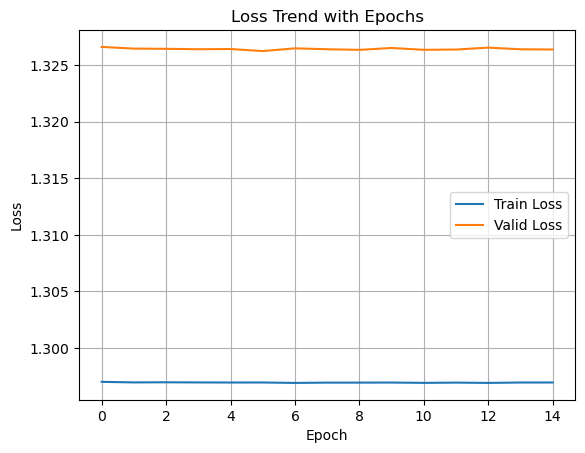

In [110]:
plot_result(trainLoss6, valLoss6)

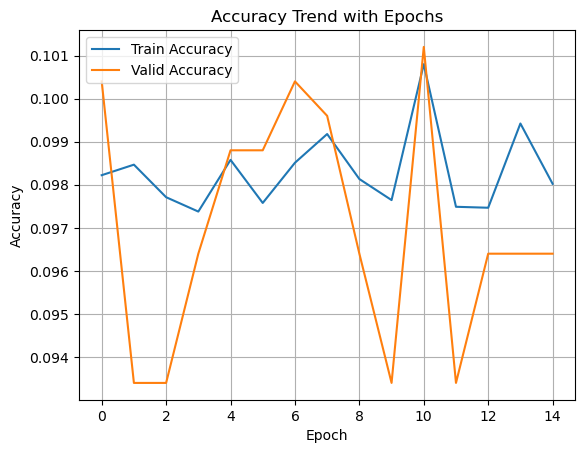

In [111]:
plot_result(trainAccuracy6, valAccuracy6, string = "Accuracy")

In [112]:
testAcc6 = test(cnn6, test_loader)

Test Acc - 0.0964



### 4.7 Batch Norm = True, Activation = "relu", Pool = "avg"

In [113]:
cnn7 = CNNModel(batch = True, activation = "relu", pool = "avg").to(device)
trainAccuracy7, trainLoss7, valAccuracy7, valLoss7 = train(cnn7, train_loader, val_loader)

Epoch - 01
Train Loss - 1.2106 | Train Acc - 0.2395
Valid loss - 1.1366 | Valid Acc - 0.3242

Epoch - 02
Train Loss - 0.9897 | Train Acc - 0.3762
Valid loss - 0.9555 | Valid Acc - 0.3994

Epoch - 03
Train Loss - 0.8428 | Train Acc - 0.4537
Valid loss - 0.8360 | Valid Acc - 0.4702

Epoch - 04
Train Loss - 0.7620 | Train Acc - 0.5040
Valid loss - 0.7640 | Valid Acc - 0.5048

Epoch - 05
Train Loss - 0.7033 | Train Acc - 0.5450
Valid loss - 0.7172 | Valid Acc - 0.5534

Epoch - 06
Train Loss - 0.6553 | Train Acc - 0.5786
Valid loss - 0.6699 | Valid Acc - 0.5824

Epoch - 07
Train Loss - 0.6137 | Train Acc - 0.6048
Valid loss - 0.6452 | Valid Acc - 0.6086

Epoch - 08
Train Loss - 0.5762 | Train Acc - 0.6342
Valid loss - 0.6017 | Valid Acc - 0.6272

Epoch - 09
Train Loss - 0.5450 | Train Acc - 0.6554
Valid loss - 0.5703 | Valid Acc - 0.6492

Epoch - 10
Train Loss - 0.5149 | Train Acc - 0.6762
Valid loss - 0.5428 | Valid Acc - 0.6736

Epoch - 11
Train Loss - 0.4862 | Train Acc - 0.6970
Valid lo

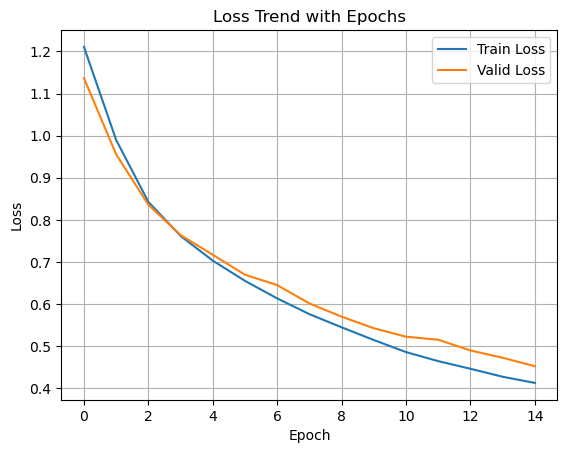

In [114]:
plot_result(trainLoss7, valLoss7)

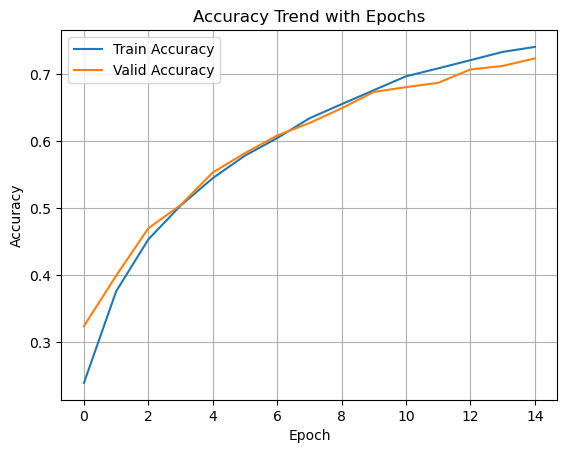

In [115]:
plot_result(trainAccuracy7, valAccuracy7, string = "Accuracy")

In [116]:
testAcc7 = test(cnn7, test_loader)

Test Acc - 0.7232



### 4.8 Batch Norm = False, Activation = "relu", Pool = "avg"

In [117]:
cnn8 = CNNModel(batch = False, activation = "relu", pool = "avg").to(device)
trainAccuracy8, trainLoss8, valAccuracy8, valLoss8 = train(cnn8, train_loader, val_loader)

Epoch - 01
Train Loss - 1.2968 | Train Acc - 0.0999
Valid loss - 1.3260 | Valid Acc - 0.1008

Epoch - 02
Train Loss - 1.2964 | Train Acc - 0.0999
Valid loss - 1.3258 | Valid Acc - 0.1008

Epoch - 03
Train Loss - 1.2959 | Train Acc - 0.1291
Valid loss - 1.3251 | Valid Acc - 0.1506

Epoch - 04
Train Loss - 1.2952 | Train Acc - 0.1526
Valid loss - 1.3240 | Valid Acc - 0.1452

Epoch - 05
Train Loss - 1.2935 | Train Acc - 0.1449
Valid loss - 1.3218 | Valid Acc - 0.1370

Epoch - 06
Train Loss - 1.2889 | Train Acc - 0.1367
Valid loss - 1.3137 | Valid Acc - 0.1408

Epoch - 07
Train Loss - 1.2705 | Train Acc - 0.1624
Valid loss - 1.2755 | Valid Acc - 0.1894

Epoch - 08
Train Loss - 1.1990 | Train Acc - 0.2222
Valid loss - 1.1949 | Valid Acc - 0.2426

Epoch - 09
Train Loss - 1.1431 | Train Acc - 0.2545
Valid loss - 1.1685 | Valid Acc - 0.2560

Epoch - 10
Train Loss - 1.1229 | Train Acc - 0.2679
Valid loss - 1.1510 | Valid Acc - 0.2736

Epoch - 11
Train Loss - 1.1089 | Train Acc - 0.2798
Valid lo

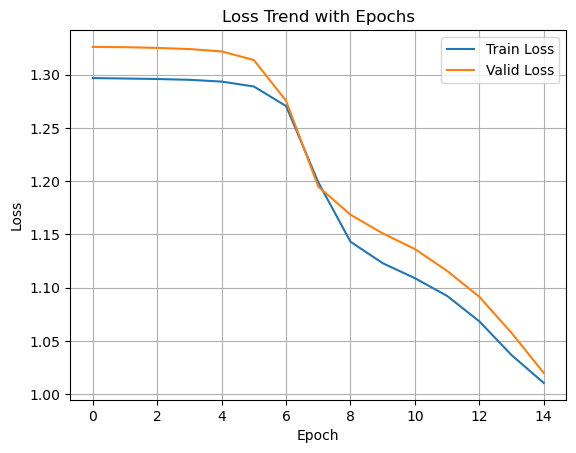

In [118]:
plot_result(trainLoss8, valLoss8)

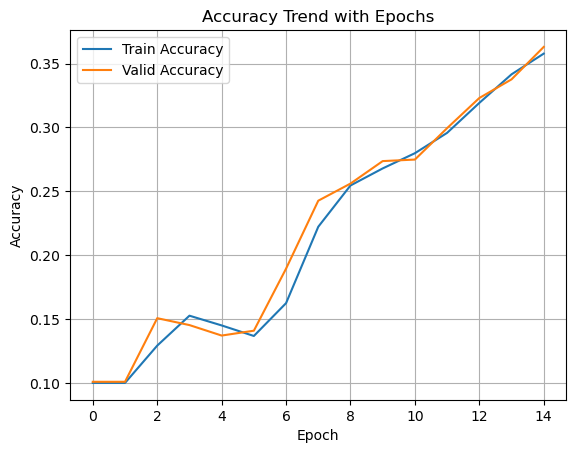

In [119]:
plot_result(trainAccuracy8, valAccuracy8, string = "Accuracy")

In [120]:
testAcc8 = test(cnn8, test_loader)

Test Acc - 0.3630

